In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import datasets
from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K
from tensorflow.python.keras.backend import set_session
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from scipy.stats import entropy
from math import log, e

In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

['irisnorm.arff']
running...
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
irisnorm,0.9266666650772095,0.7026685634459315
Done!


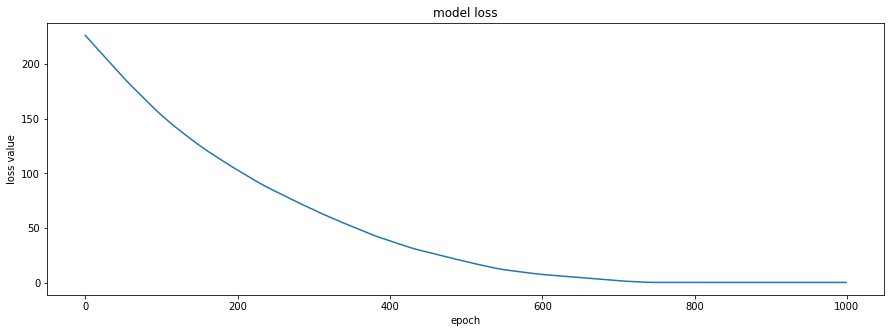

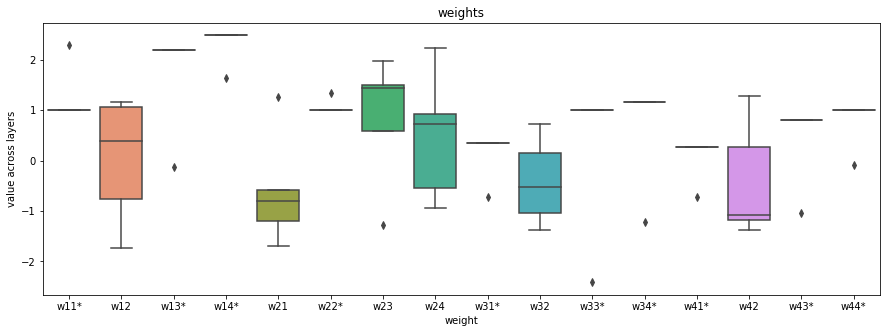

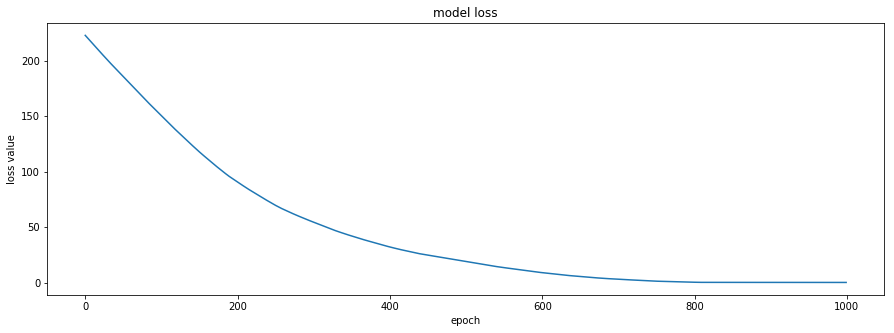

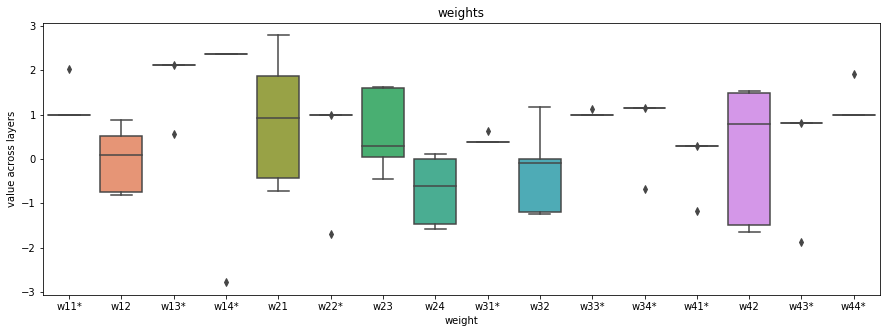

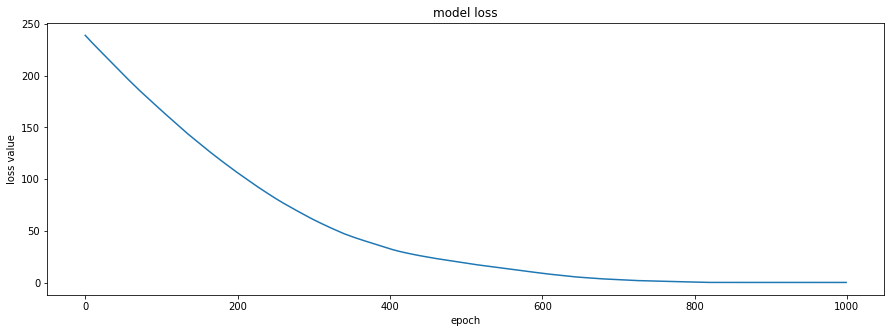

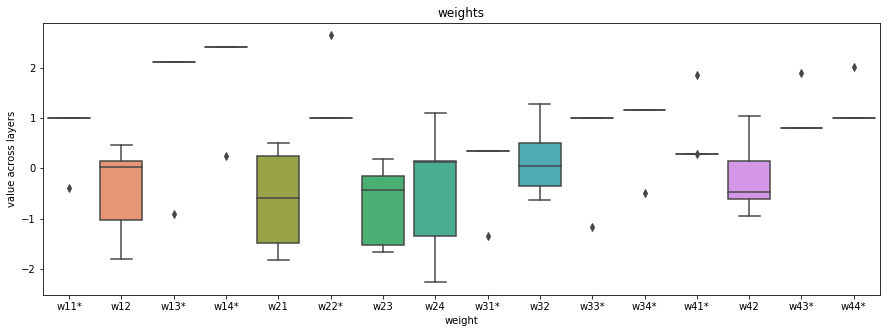

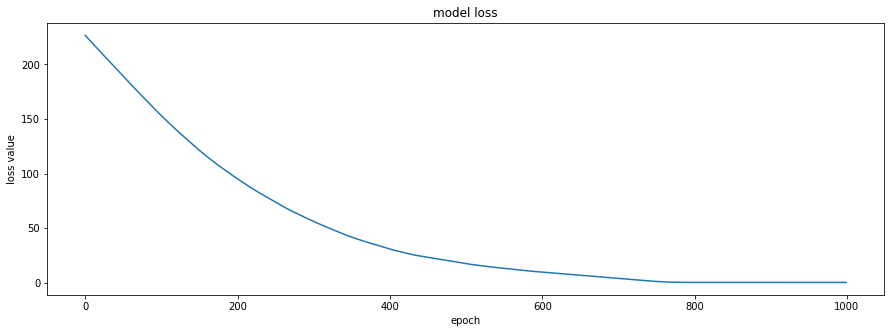

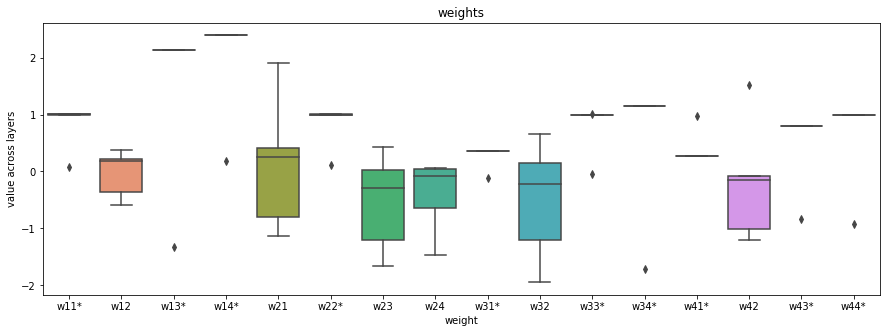

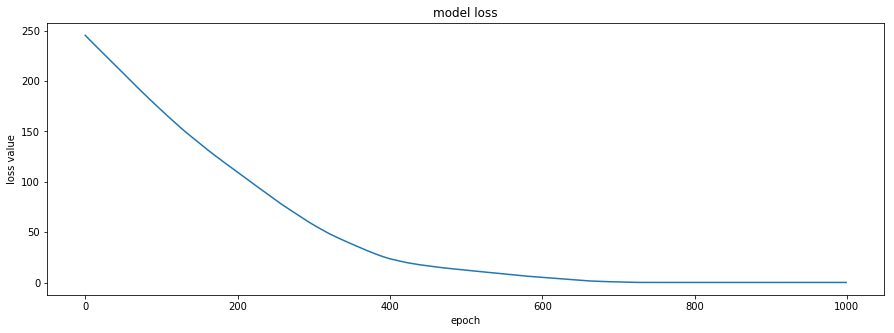

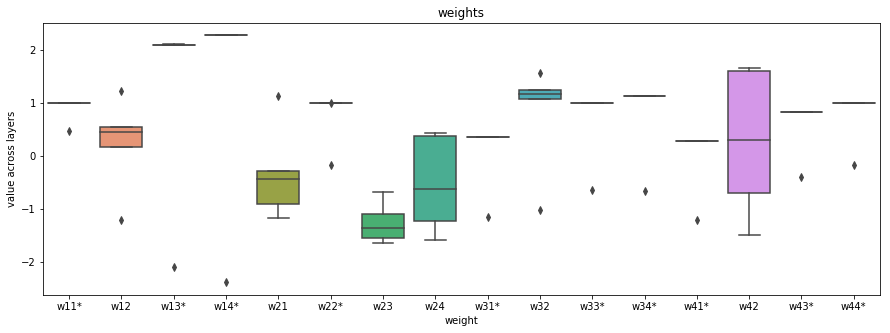

In [11]:
import warnings
warnings.filterwarnings("ignore")


class WeightRegularizer(tf.keras.regularizers.Regularizer):

    def __init__(self, coef, mask):
        self.coef = coef
        self.mask = mask

    def __call__(self, weight_matrix):
        tensor = tf.convert_to_tensor(self.coef, np.float32)
        reg1 = K.sum(K.abs(tf.math.multiply(tf.math.subtract(weight_matrix,tensor), self.mask)))
        reg2 = 0.001 * K.sum(K.square(weight_matrix))
        return reg1 + reg2

    def get_config(self):
        return {'coefficients': self.coef, 'penalization': self.mask}
    

def run_model(file, layers=5, folds=5, epochs=1000, verbose=True, regularize=True):
    X, y, out = read_arff(file)
    hidden = len(X[0])
    
    skf = StratifiedKFold(n_splits=folds)
    skf.get_n_splits(X, y)
    
    acc_arr = []
    ent_arr = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = np.asarray(X[train_index]).astype(np.float32),np.asarray(X[test_index]).astype(np.float32) #X[train_index], X[test_index]
        y_train, y_test = np.asarray(y[train_index]).astype(np.float32),np.asarray(y[test_index]).astype(np.float32) #y[train_index], y[test_index]
        X = np.asarray(X).astype(np.float32)
        if(regularize):
            coef, mask = coefficients(matrix=X_train)
            network = [tf.keras.layers.Flatten()]     
    
        for i in range(layers):
            reg = None if (i == layers-1 or not regularize) else WeightRegularizer(coef, mask)
            dense = tf.keras.layers.Dense(hidden, activation=tf.nn.tanh, kernel_regularizer=reg)
            network.append(dense)

        network.append(tf.keras.layers.Dense(out, activation=tf.nn.softmax))

        model = tf.keras.models.Sequential(network)
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        print(type(X_train))
        history = model.fit(X_train, y_train, epochs=epochs, verbose=0)
        
        if(verbose):
            plot_loss_weights(history, model, mask)
        
        weights = model.get_weights()
        relajo = error(weights, coef, mask)
        ent_arr.append(relajo)
        
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        acc_arr.append(acc)

    return np.mean(acc_arr), np.mean(ent_arr)

def coefficients(matrix):
    n, m = matrix.shape
    temp1 = np.sum(matrix, axis=0)
    temp2 = np.sum(matrix**2, axis=0)
    
    df_data = pd.DataFrame(data=matrix,dtype=float)
    pearson = np.array(df_data.corr())
    
    mask = np.zeros((m, m))
    coef = np.zeros((m, m))
    for i in range(0, m):
        for j in range(0, m):
            den = n * temp2[i] - temp1[i] ** 2
            if (den != 0):
                coef[i,j] = (n * np.sum(matrix[:,i] * matrix[:,j]) - temp1[i] * temp1[j]) / den
                
                if(abs(pearson[i,j]) > 0.5):
                    mask[i,j] = log(n)
 
    return coef, mask

def plot_loss_weights(history, model, mask):
    fig1, axes1 = plt.subplots(figsize=(15,5))
    fig2, axes2 = plt.subplots(figsize=(15,5))
        
    # plotting the training loss
    axes1.plot(history.history['loss'])
    axes1.set_title('model loss')
    axes1.set(ylabel='loss value', xlabel='epoch')

    # plotting the weights
    weights = model.get_weights()

    data = [xi.flatten().tolist() for xi in weights[:-2:2]]
    df = pd.DataFrame(data)
    
    header = []
    for i in range(len(mask)):
        for j in range(len(mask)):
            header.append('w'+str(i+1)+str(j+1)+"*" if (mask[i,j] != 0) else 'w'+str(i+1)+str(j+1))
            
    df.columns = header
    import seaborn as sns
    axes2 = sns.boxplot(data=df)
    axes2.set_title('weights')
    axes2.set(ylabel='value across layers', xlabel='weight')
    
def error(weights, coef, mask):
    if(np.sum(mask) == 0):
        return 0
    
    coef = coef.flatten()
    mask = mask.flatten()
    array = []
    
    count = 0
    matrix = [xi.flatten() for xi in weights[:-2:2]]
    for i in range(len(matrix[0])):
        layer = column(matrix, i)
        for j in range(len(layer)):
            if(mask[j] > 0):
                den = max(1, max(layer[j], coef[j]))
                array.append(abs(layer[j] - coef[j]) / den)
                count += 1

    return np.sum(array)/count

def column(matrix, i):
    return [row[i] for row in matrix]
    
def read_arff(file):
    # reading from .arff file
    # consistency, in the MP algorithm we take the arff without header, so we cannot req header here
    from scipy.io import arff
    data, meta = arff.loadarff(file)
    frame = pd.DataFrame(data)
    class_att = meta.names()[-1]
    y = frame[class_att]
    labels = np.unique(y)
    mapping = pd.Series([x[0] for x in enumerate(labels)], index = labels)
    y = np.array(y.map(mapping))
    X = np.array(frame)[:,0:-1]
    return X, y, len(labels)    
    
def run_exp(path):
    import os
    files = os.listdir(path)
    print(files)
    print("running...")
  
    for file in files:
        if ".arff" not in file:
            print("no")
        acc, ent = run_model(path + "/" + file)
        print(file.replace('.arff','') + "," + str(acc)+ "," + str(ent))
    return 0

run_exp('data')
print("Done!")

In [6]:
".arff" in "file"

False